## NN Overfitting and How to Fix It

##### Credits: [Radoslav Neychev](https://www.linkedin.com/in/radoslav-neychev/), @neychev

In [1]:
# do not change the code in the block below
# __________start of block__________
from collections import OrderedDict
import json
import os
import re

import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import FashionMNIST

# __________end of block__________

In [6]:
# do not change the code in the block below
# __________start of block__________

def parse_pytorch_model(model, device):
    H, W = 28, 28
    sample_input = torch.randn(1, 1, H, W).to(device=device)
    supported_modules = [
        nn.Linear, nn.Flatten, nn.Dropout, nn.Dropout2d,
        nn.ReLU, nn.LeakyReLU,
        nn.Conv1d, nn.Conv2d,
        nn.BatchNorm1d, nn.BatchNorm2d,
        nn.MaxPool2d, nn.AvgPool2d,
        nn.AdaptiveAvgPool2d, nn.AdaptiveMaxPool2d,
    ]
    def register_hook(module):
        def hook(module, input, output):
            module_idx = len(model_dict["layers"])
            if any([isinstance(module, instance) for instance in supported_modules]):
                model_dict["layers"].append(
                    {
                        "index": module_idx,
                        "layer": {
                            "type": module.__class__.__name__,
                            "params": str(module),
                        }
                    }
                )
        if (
            not isinstance(module, nn.Sequential)
            and not isinstance(module, nn.ModuleList)
        ):
            hooks.append(module.register_forward_hook(hook))
    
    model_dict = {
        "model_name": model.__class__.__name__,
        "layers": []
    }
    hooks = []
    model.apply(register_hook)
    _ = model(sample_input)
    # remove hooks
    for h in hooks:
        h.remove()
    return model_dict

# __________end of block__________

In [8]:
# do not change the code in the block below
# __________start of block__________
def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())

    predicted_labels = torch.cat(predicted_labels)
    predicted_labels = ",".join([str(x.item()) for x in list(predicted_labels)])
    return predicted_labels


def get_accuracy(model, data_loader):
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            y_predicted = model(batch[0].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())
            real_labels.append(batch[1])

    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    accuracy_score = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    return accuracy_score


# __________end of block__________

Load file `hw_overfitting_data_dict.npy` (link is on the task page), it will be used to generate submissions. Code below helps to load it (in case error occurs, download the file manually).


In [9]:
!wget https://github.com/girafe-ai/ml-course/blob/26s_harbour/homeworks/hw005_fmnist/hw_overfitting_data_dict.npy

zsh:1: command not found: wget


In [10]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

# __________end of block__________

### Task #1: Creating and training a model (Separation)
Let's go back to the simple image classification task which was discussed earlier. But now we will utilize the [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. Let's use full dataset fot this task.

__Your first task: implement the entire model training pipeline and reach accuracy baseline of $\geq 88.5\%$ on the test set.__

There is no code for training the model in this task. There are only a few tests that will help you debug your solution. You may use notebook practice from previous class as a reference.

In [11]:
CUDA_DEVICE_ID = 0  # change if needed

In [12]:
# do not change the code in the block below
# __________start of block__________
device = (
    torch.device(f"cuda:{CUDA_DEVICE_ID}") if torch.cuda.is_available() else torch.device("cpu")
)
# __________end of block__________

Text(0.5, 1.0, 'Image label: 8')

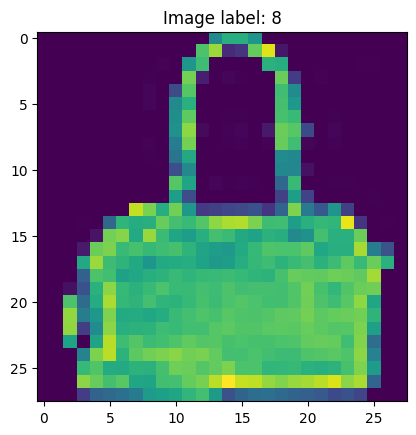

In [13]:
# do not change the code in the block below
# __________start of block__________

train_fmnist_data = FashionMNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_fmnist_data = FashionMNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
)


train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data, batch_size=32, shuffle=True, num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_fmnist_data, batch_size=32, shuffle=False, num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

Define your model in the code block below. Please don't make it too complicated, don't use more than 4 layers (it can be even less actually). Your main goal is to train the model and exceed `accuracy` baseline of 88.5%.

__ATTENTION, your model has to be defined in `model_task_1` variable. It should use batches of input tensors of shape (1, 28, 28).__

In [14]:
import torch.optim as optim

class FashionMLP(nn.Module):
    def __init__(self):
        super(FashionMLP, self).__init__()
        self.flatten = nn.Flatten()
        
        self.layers = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers(x)
        return logits

model_task_1 = FashionMLP().to(device)

Don't forget to move your model to the `device`!

In [15]:
model_task_1.to(device)

FashionMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

Local unit tests for sanity check are given below:

In [16]:
# do not change the code in the block below
# __________start of block__________
assert model_task_1 is not None, "Please, use `model_task_1` variable to store your model"

try:
    x = random_batch[0].to(device)
    y = random_batch[1].to(device)

    # compute outputs given inputs, both are variables
    y_predicted = model_task_1(x)
except Exception as e:
    print("Something is wrong with the model")
    raise e


assert y_predicted.shape[-1] == 10, "Model should predict 10 logits/probas"

print("Everything seems fine!")
# __________end of block__________

Everything seems fine!


Set up model hyperparameters for training. It's worth adjusting `learning rate` parameter as well.

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_task_1.parameters(), lr=0.001)
num_epochs = 15 

for epoch in range(num_epochs):
    model_task_1.train()  
    running_loss = 0.0
    
    for images, labels in train_data_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model_task_1(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_data_loader):.4f}")

model_task_1.eval()  
correct = 0
total = 0

with torch.no_grad(): 
    for images, labels in test_data_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model_task_1(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Final Accuracy on Test Set: {accuracy:.2f}%")

Epoch [1/15], Loss: 0.5010
Epoch [2/15], Loss: 0.3615
Epoch [3/15], Loss: 0.3253
Epoch [4/15], Loss: 0.3065
Epoch [5/15], Loss: 0.2841
Epoch [6/15], Loss: 0.2707
Epoch [7/15], Loss: 0.2566
Epoch [8/15], Loss: 0.2474
Epoch [9/15], Loss: 0.2340
Epoch [10/15], Loss: 0.2251
Epoch [11/15], Loss: 0.2158
Epoch [12/15], Loss: 0.2084
Epoch [13/15], Loss: 0.2007
Epoch [14/15], Loss: 0.1926
Epoch [15/15], Loss: 0.1860
Final Accuracy on Test Set: 89.41%


Don't forget to read the great [docs](https://pytorch.org/docs/stable/index.html) and [tutorials](https://pytorch.org/tutorials/).  

Evaluate accuracy:

In [18]:
train_acc_task_1 = get_accuracy(model_task_1, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_1:3.5}")

Neural network accuracy on train set: 0.93747


In [19]:
test_acc_task_1 = get_accuracy(model_task_1, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_1:3.5}")

Neural network accuracy on test set: 0.8941


Asserts for passing accuracy baseline:

In [20]:
assert test_acc_task_1 >= 0.885, "Train accuracy is below 0.885 threshold"
assert (
    train_acc_task_1 >= 0.905
), "Test accuracy is below 0.905 while test accuracy is fine. We recommend to check your model and data flow"

Note that code below expected your model to be defined in `model_task_1` variable.

In [21]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict = {
    "train_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["train"])
    ),
    "test_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["test"])
    ),
    "model_task_1": parse_pytorch_model(model_task_1, device),
}

with open("submission_dict_task_1.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_task_1.json`")
# __________end of block__________

File saved to `submission_dict_task_1.json`


### Task #2: Overfitting (Initiation)
We're still working with the [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. Now the task is to demonstrate model overfitting on the training set. In other words we need to demonstrate classification accuracy (not the loss value!), which is significantly higher for the training set in comparison with the testing set.

Please note that in task #3 you will have to fix this model (reduce overfitting) using regularization, so don't overdo it!

__Your second task: implement model training pipeline to demonstrate model ovefitting for the training set.__

You can reuse some training code from above. There are a few tests further to help you check your solution.

Note that for this task model has to be defined in variable `model_task_2`.

Don't use `Dropout` and `BatchNorm` for this task.

In [127]:
class OverfittingModel(nn.Module):
    def __init__(self):
        super(OverfittingModel, self).__init__()
        self.flatten = nn.Flatten()
        self.stack = nn.Sequential(
            nn.Linear(28*28, 600),
            nn.ReLU(),
            nn.Linear(600, 600),
            nn.ReLU(),
            nn.Linear(600, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.stack(x)
        return logits

model_task_2 = OverfittingModel().to(device)

In [ ]:
model_task_2 = OverfittingModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_task_2.parameters(), lr=0.001)

num_epochs = 40

for epoch in range(num_epochs):
    model_task_2.train()
    train_correct = 0
    train_total = 0
    
    for images, labels in train_data_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model_task_2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_acc = 100 * train_correct / train_total
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Acc: {train_acc:.2f}%")

model_task_2.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_task_2(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = 100 * test_correct / test_total

print("-" * 30)
print(f"Final Training Accuracy: {train_acc:.2f}%")
print(f"Final Test Accuracy:     {test_acc:.2f}%")
print(f"Overfitting Gap:         {train_acc - test_acc:.2f}%")
print("-" * 30)

Epoch [1/40] | Train Acc: 69.27%
Epoch [2/40] | Train Acc: 75.16%
Epoch [3/40] | Train Acc: 77.00%
Epoch [4/40] | Train Acc: 78.23%
Epoch [5/40] | Train Acc: 79.20%
Epoch [6/40] | Train Acc: 79.65%
Epoch [7/40] | Train Acc: 80.56%
Epoch [8/40] | Train Acc: 80.88%
Epoch [9/40] | Train Acc: 81.16%
Epoch [10/40] | Train Acc: 81.46%
Epoch [11/40] | Train Acc: 81.73%
Epoch [12/40] | Train Acc: 82.02%
Epoch [13/40] | Train Acc: 82.27%
Epoch [14/40] | Train Acc: 82.30%
Epoch [15/40] | Train Acc: 82.57%
Epoch [16/40] | Train Acc: 82.83%
Epoch [17/40] | Train Acc: 82.80%
Epoch [18/40] | Train Acc: 82.87%
Epoch [19/40] | Train Acc: 83.35%
Epoch [20/40] | Train Acc: 83.35%
Epoch [21/40] | Train Acc: 83.18%
Epoch [22/40] | Train Acc: 83.70%
Epoch [23/40] | Train Acc: 83.73%
Epoch [24/40] | Train Acc: 83.60%
Epoch [25/40] | Train Acc: 83.92%
Epoch [26/40] | Train Acc: 84.10%
Epoch [27/40] | Train Acc: 84.13%


NN architecture check:

In [120]:
# do not change the code in the block below
# __________start of block__________
layers_task_2 = []
for element in parse_pytorch_model(model_task_2, device).get("layers", []):
    layer_name = element["layer"]["type"]
    assert "dropout" not in layer_name.lower(), "Do not use Dropout in Task 2!"
    assert "batchnorm" not in layer_name.lower(), "Do not use BatchNorm in Task 2!"
    layers_task_2.append(layer_name)
# __________end of block__________

Estimate accuracy:

In [121]:
train_acc_task_2 = get_accuracy(model_task_2, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_2:3.5}")

Neural network accuracy on train set: 0.83685


In [123]:
test_acc_task_2 = get_accuracy(model_task_2, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_2:3.5}")

Neural network accuracy on test set: 0.8441


Test that there is definitely overfitting:

In [126]:
assert train_acc_task_2 >= test_acc_task_2, "Train accuracy must be higher than task accuracy"
assert train_acc_task_2 >= 0.88, "Train accuracy must be higher than 0.88"
assert (
    train_acc_task_2 - test_acc_task_2 >= 0.04
), "Test accuracy should be at least 0.04 lower that train."

AssertionError: Train accuracy must be higher than task accuracy

Note once again that for the code below to work your model has to be defined in `model_task_2` variable.

Also note that `submission_dict` variable already has saved results from task #1. If it does not, reload them from the saved file to this variable before running the next cell.

In [28]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict.update(
    {
        "train_predictions_task_2": get_predictions(
            model_task_2, torch.FloatTensor(loaded_data_dict.item()["train"])
        ),
        "test_predictions_task_2": get_predictions(
            model_task_2, torch.FloatTensor(loaded_data_dict.item()["test"])
        ),
        "model_task_2": parse_pytorch_model(model_task_2, device),
    }
)

with open("submission_dict_tasks_1_and_2.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_tasks_1_and_2.json`")
# __________end of block__________

File saved to `submission_dict_tasks_1_and_2.json`


### Task #3: Fix the model (Return) 
We're still working with [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). Finally, let's fix overfitting issue for the model from task#2. By fixing it means to achieve classification accuracy difference of 0.015 (=1.5%) for training and testing accuracy using a new updated model.

Note that model architecture in task#3 should not be very different from task#2! You can use Batchnorm, Dropout, data augmentation and also reduce the channel number. You can not reduce the number of layers!


__Your third and final task: fix the model and/or training pipeline to fix overfitting.__

Once again you can reuse model training code. As usual there are a few tests below for sanity check.

Note that for this task model has to be defined in variable `model_task_3`.

Code below will also access `layers_task_2` variable. Define it if it was not defined before.

In [77]:
# do not change the code in the block below
# __________start of block__________
assert (
    layers_task_2 is not None
), "Initialize layers_task_2 vairable which contains list of layers in task 2 model"
# __________end of block__________

In [87]:
layers_task_2 = []
for element in parse_pytorch_model(model_task_2, device).get("layers", []):
    layer_name = element["layer"]["type"]
    layers_task_2.append(layer_name)

class RegularizedModel(nn.Module):
    def __init__(self):
        super().__init__()
        h = 192
        self.noise_std = 0.05
        self.flatten = nn.Flatten()
        self.stack = nn.Sequential(
            nn.Linear(28 * 28, h),
            nn.ReLU(),
            nn.BatchNorm1d(h),
            nn.Dropout(p=0.3),

            nn.Linear(h, h),
            nn.ReLU(),
            nn.BatchNorm1d(h),
            nn.Dropout(p=0.3),

            nn.Linear(h, 10),
        )

    def forward(self, x):
        if self.training and self.noise_std > 0:   
            x = x + torch.randn_like(x) * self.noise_std
        x = self.flatten(x)
        return self.stack(x)

model_task_3 = RegularizedModel().to(device)

In [97]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_task_3.parameters(), lr=0.001, weight_decay=3e-4)

num_epochs = 15

for epoch in range(num_epochs):
    model_task_3.train()
    train_correct = 0
    train_total = 0
    
    for images, labels in train_data_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model_task_3(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_acc = 100 * train_correct / train_total
    
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Acc: {train_acc:.2f}%")

model_task_3.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_task_3(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = 100 * test_correct / test_total
gap = train_acc - test_acc

print("-" * 30)
print(f"Final Train Accuracy: {train_acc:.2f}%")
print(f"Final Test Accuracy:  {test_acc:.2f}%")
print(f"Gap: {gap:.2f}%")

Epoch [1/15] Train Acc: 85.59%
Epoch [2/15] Train Acc: 85.76%
Epoch [3/15] Train Acc: 85.25%
Epoch [4/15] Train Acc: 85.25%
Epoch [5/15] Train Acc: 85.37%
Epoch [6/15] Train Acc: 85.42%
Epoch [7/15] Train Acc: 85.54%
Epoch [8/15] Train Acc: 85.44%
Epoch [9/15] Train Acc: 85.41%
Epoch [10/15] Train Acc: 85.51%
Epoch [11/15] Train Acc: 85.62%
Epoch [12/15] Train Acc: 85.44%
Epoch [13/15] Train Acc: 85.62%
Epoch [14/15] Train Acc: 85.74%
Epoch [15/15] Train Acc: 85.62%
------------------------------
Final Train Accuracy: 85.62%
Final Test Accuracy:  86.53%
Gap: -0.91%


Check NN architecture:

In [ ]:
# do not change the code in the block below
# __________start of block__________
layers_task_3 = []
for element in parse_pytorch_model(model_task_3, device).get("layers", []):
    layer_name = element["layer"]["type"]
    layers_task_3.append(layer_name)


idx = 0
for model_3_layer in layers_task_3:
    model_2_layer = layers_task_2[idx]
    if "dropout" not in model_3_layer.lower() and "batchnorm" not in model_3_layer.lower():
        assert (
            model_3_layer == model_2_layer
        ), "Models in tasks 2 and 3 must share the architecture except for Dropout and BatchNorm!"
        idx += 1
# __________end of block__________

Estimate classification accuracy:

In [94]:
train_acc_task_3 = get_accuracy(model_task_3, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_3:3.5}")

Neural network accuracy on train set: 0.87262


In [95]:
test_acc_task_3 = get_accuracy(model_task_3, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_3:3.5}")

Neural network accuracy on test set: 0.8542


Check if overfitting is still here:

In [96]:
assert train_acc_task_3 >= 0.88, "Train accuracy must be higher than 0.88"
assert train_acc_task_3 >= 0.865, "Test accuracy must be higher than 0.865"
print(train_acc_task_3 - test_acc_task_3)
assert (
    train_acc_task_3 - test_acc_task_3 <= 0.015
), "Test accuracy should not be lower that train more than by 0.015"

AssertionError: Train accuracy must be higher than 0.88

Note that code below thinks that your model is defined in variable `model_task_3`.

Also note that `submission_dict` variable should already have saved results from tasks #1 and #2. If it does not, reload them from the saved files before running the next cell.

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict.update(
    {
        "train_predictions_task_3": get_predictions(
            model_task_3, torch.FloatTensor(loaded_data_dict.item()["train"])
        ),
        "test_predictions_task_3": get_predictions(
            model_task_3, torch.FloatTensor(loaded_data_dict.item()["test"])
        ),
        "model_task_3": parse_pytorch_model(model_task_3, device),
    }
)

with open("submission_dict_final.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_final.json`")
# __________end of block__________

### Submit the results for automatic grading
Submit generated files to the corresponding contest tasks:
    
* `submission_dict_task_1.json` to Separation
* `submission_dict_tasks_1_and_2.json` to Initiation
* `submission_dict_final.json` to Return.

The task is finished! Congrats!